## Practice 2 - Hands-on practice with pre-trained neural network architectures

**TÊN : Nguyễn Văn Thương**

**MSSV : 077205005581**

# 1. Environment setup
đã thiết lập môi trường PyTorch và torchvision.

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
import time


# 2. Load a Pre-trained Model

In [50]:
# Chọn thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Tải mô hình VGG16 đã được huấn luyện trên ImageNet
model = models.vgg16(pretrained=True)

Using device: cpu


# 3. Explore the Model Architecture

In [51]:
# In ra toàn bộ cấu trúc mô hình
print(model)

# In riêng phần classifier để xem lớp cuối
print("\n--- Classifier Layers ---")
print(model.classifier)

# In số lượng tham số (parameters) có thể huấn luyện
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 4. Adapt the Model for a Specific Task

In [52]:
# Đóng băng toàn bộ trọng số để không cập nhật trong giai đoạn đầu
for param in model.features.parameters():
    param.requires_grad = False

# Thay thế lớp cuối của classifier
num_classes = 10
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device)


# 5. Prepare the Data

In [53]:
#Biến đổi dữ liệu đầu vào (chuẩn hóa + resize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG16 yêu cầu input 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#Load dữ liệu từ thư mục có sẵn
train_dir = "data/train"
test_dir = "data/test"

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

#Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# 6. Train the Model

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=1e-4)
writer = SummaryWriter('runs/vgg16_experiment') 

In [55]:
dummy_input = torch.randn(1, 3, 224, 224)
writer.add_graph(model, dummy_input)

In [56]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    acc = 100 * correct / total
    writer.add_scalar('Training Loss', running_loss / len(train_loader), epoch)
    writer.add_scalar('Training Accuracy', acc, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.3f}, Accuracy: {acc:.2f}%")

writer.close()


Epoch [1/10], Loss: 2.700, Accuracy: 0.00%
Epoch [2/10], Loss: 2.419, Accuracy: 12.50%
Epoch [3/10], Loss: 2.293, Accuracy: 18.75%
Epoch [4/10], Loss: 2.264, Accuracy: 31.25%
Epoch [5/10], Loss: 2.139, Accuracy: 12.50%
Epoch [6/10], Loss: 1.828, Accuracy: 50.00%
Epoch [7/10], Loss: 1.812, Accuracy: 50.00%
Epoch [8/10], Loss: 1.761, Accuracy: 31.25%
Epoch [9/10], Loss: 1.511, Accuracy: 50.00%
Epoch [10/10], Loss: 1.555, Accuracy: 62.50%


# 7. Evaluate the Model

In [60]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40222222..1.5934205].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5075778..1.4954481].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2763936..1.8112855].


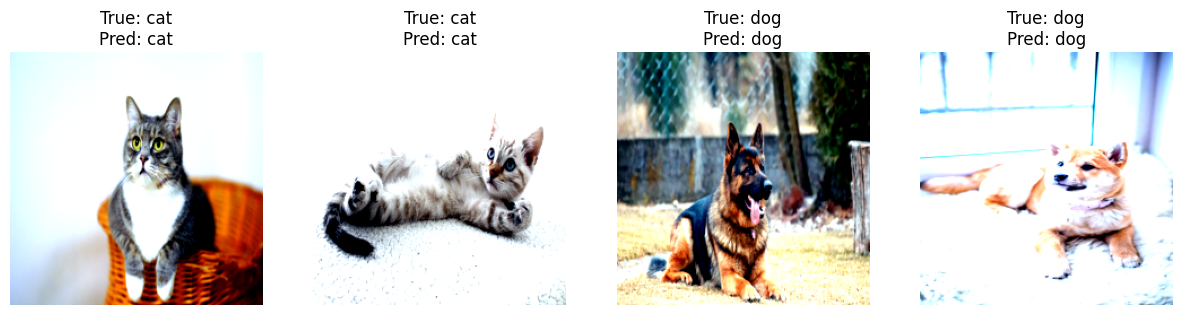

In [61]:
import matplotlib.pyplot as plt
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = model(images)
_, preds = torch.max(outputs, 1)

class_names = test_loader.dataset.classes

fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i in range(len(images)):
    ax = axes[i]
    img = images[i] / 2 + 0.5  # unnormalize nếu bạn normalize ở bước preprocess
    npimg = img.numpy().transpose((1, 2, 0))
    ax.imshow(npimg)
    ax.set_title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
    ax.axis('off')

plt.show()

Accuracy on test set: 100.00%


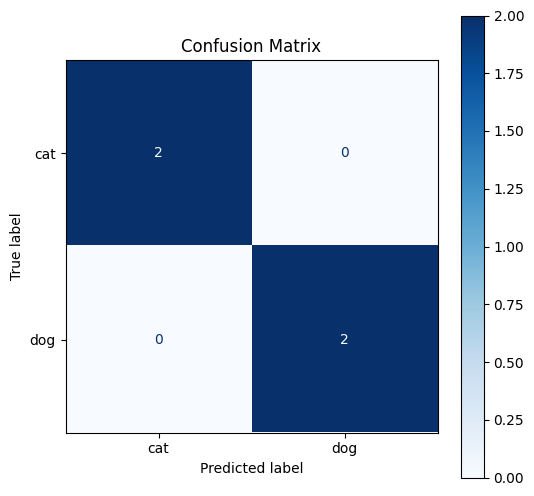

In [62]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Đánh giá mô hình và lưu nhãn dự đoán/thật
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = 100 * np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Accuracy on test set: {acc:.2f}%")

# Vẽ confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()